In [1]:
!pip install groq python-dotenv langgraph networkx matplotlib

  Using cached langgraph-0.2.59-py3-none-any.whl.metadata (15 kB)
  Using cached matplotlib-3.9.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached langchain_core-0.3.24-py3-none-any.whl.metadata (6.3 kB)
  Using cached langgraph_checkpoint-2.0.8-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_sdk-0.1.43-py3-none-any.whl.metadata (1.8 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached langgraph-0.2.59-py3-none-any.whl (135 kB)
Using cached matplotlib-3.9.3-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached langchain_core-0.3.24-py3-none-any.whl (410 kB)
Using cached langgraph_checkpoint-2.0.8-py3-none-any.whl (35 kB)
Using cached langgraph_sdk-0.1.43-py3-none-any.whl (31 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langc

C:\Users\Coditas-Admin\AppData\Local\Temp\ipykernel_2284\2591036977.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


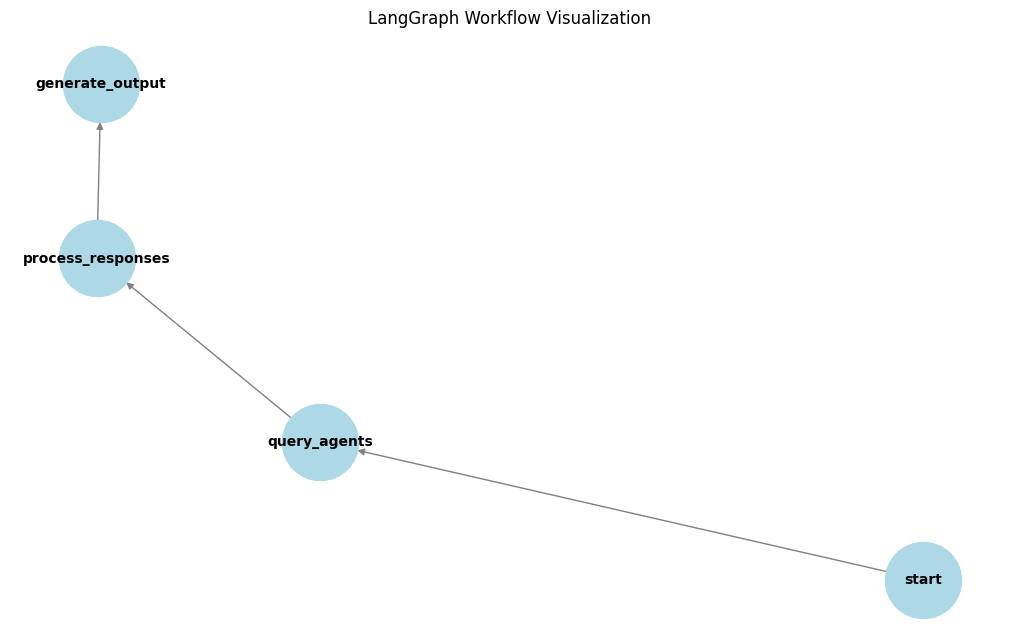

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import networkx as nx
import matplotlib.pyplot as plt

class WorkflowState(TypedDict):
    topic: str
    responses: list

def create_sample_workflow():
    # Create a simple StateGraph
    workflow = StateGraph(WorkflowState)

    # Add nodes to the workflow
    workflow.add_node("start", lambda state: state)
    workflow.add_node("query_agents", lambda state: state)
    workflow.add_node("process_responses", lambda state: state)
    workflow.add_node("generate_output", lambda state: state)

    # Define workflow edges
    workflow.add_edge(START, "start")
    workflow.add_edge("start", "query_agents")
    workflow.add_edge("query_agents", "process_responses")
    workflow.add_edge("process_responses", "generate_output")
    workflow.add_edge("generate_output", END)

    return workflow

def visualize_workflow(workflow):
    # Convert LangGraph to networkx graph
    nx_graph = nx.DiGraph()
    
    # Add nodes
    nodes = [
        "start", 
        "query_agents", 
        "process_responses", 
        "generate_output"
    ]
    nx_graph.add_nodes_from(nodes)
    
    # Add edges
    edges = [
        ("start", "query_agents"),
        ("query_agents", "process_responses"),
        ("process_responses", "generate_output")
    ]
    nx_graph.add_edges_from(edges)
    
    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(nx_graph, seed=42)
    nx.draw(nx_graph, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=3000, 
            font_size=10, 
            font_weight='bold', 
            arrows=True, 
            edge_color='gray')
    
    plt.title("LangGraph Workflow Visualization")
    plt.tight_layout()
    plt.show()

# Create and visualize the workflow
workflow = create_sample_workflow()
visualize_workflow(workflow)

In [4]:
# Virtual Scientist System for Jupyter Notebook

import asyncio
from groq import Groq
from prompts import S1_PROMPT, S2_PROMPT, S3_PROMPT, GROQ_FINAL_PROMPT
from dotenv import load_dotenv
from langgraph.graph import Graph, StateGraph, START, END
from typing import TypedDict
import networkx as nx
import matplotlib.pyplot as plt

load_dotenv()

class ScientistState(TypedDict):
    topic: str
    s1_response: str
    s2_response: str
    s3_response: str
    final_abstract: str
    additional_notes: str

class Scientist:
    def __init__(self, name, agent, prompt):
        self.name = name
        self.agent = agent
        self.prompt = prompt
        self.response = None

    def query_tool(self, topic):
        print(f"{self.name} is querying the agent for the topic '{topic}'...")
        completion = self.agent.chat.completions.create(
            model="llama3-8b-8192",
            messages=[{"role": "system", "content": self.prompt}, {"role": "user", "content": topic}],
            temperature=1,
            max_tokens=1024,
            top_p=1,
            stream=False,
            stop=None,
        )
        self.response = completion.choices[0].message.content
        print(f"Response from {self.name}: {self.response[:200]}...")  # Truncated for brevity
        return self.response

def query_agent_s1(state: ScientistState):
    groq_agent = Groq()
    scientist_s1 = Scientist("S1", groq_agent, S1_PROMPT)
    response = scientist_s1.query_tool(state['topic'])
    return {'s1_response': response}

def query_agent_s2(state: ScientistState):
    groq_agent = Groq()
    scientist_s2 = Scientist("S2", groq_agent, S2_PROMPT)
    response = scientist_s2.query_tool(state['topic'])
    return {'s2_response': response}

def query_agent_s3(state: ScientistState):
    groq_agent = Groq()
    scientist_s3 = Scientist("S3", groq_agent, S3_PROMPT)
    response = scientist_s3.query_tool(state['topic'])
    return {'s3_response': response}

def abstract_generation(state: ScientistState):
    final_abstract = GROQ_FINAL_PROMPT.format(
        S1_FINDINGS=state['s1_response'],
        S2_FINDINGS=state['s2_response'],
        S3_FINDINGS=state['s3_response']
    )

    client = Groq()
    completion = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "system", "content": final_abstract}],
        temperature=0.7,
    )
    
    final_abstract_response = completion.choices[0].message.content
    return {'final_abstract': final_abstract_response}

def create_workflow():
    workflow = StateGraph(ScientistState)

    workflow.add_node("start", lambda state: state)
    workflow.add_node("query_s1", query_agent_s1)
    workflow.add_node("query_s2", query_agent_s2)
    workflow.add_node("query_s3", query_agent_s3)
    workflow.add_node("abstract_generation", abstract_generation)

    workflow.add_edge(START, "start")
    
    workflow.add_conditional_edges(
        "start", 
        lambda _: ["query_s1", "query_s2", "query_s3"],
        {
            "query_s1": "query_s1",
            "query_s2": "query_s2",
            "query_s3": "query_s3"
        }
    )

    workflow.add_edge("query_s1", "abstract_generation")
    workflow.add_edge("query_s2", "abstract_generation")
    workflow.add_edge("query_s3", "abstract_generation")
    workflow.add_edge("abstract_generation", END)

    return workflow

def visualize_workflow(workflow):
    """Visualize the workflow graph using networkx and matplotlib"""
    # Convert LangGraph to networkx graph
    nx_graph = nx.DiGraph()
    
    # Add nodes
    nodes = [
        "start", 
        "query_s1", 
        "query_s2", 
        "query_s3", 
        "abstract_generation"
    ]
    nx_graph.add_nodes_from(nodes)
    
    # Add edges based on workflow
    edges = [
        ("start", "query_s1"),
        ("start", "query_s2"),
        ("start", "query_s3"),
        ("query_s1", "abstract_generation"),
        ("query_s2", "abstract_generation"),
        ("query_s3", "abstract_generation")
    ]
    nx_graph.add_edges_from(edges)
    
    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(nx_graph, seed=42)
    nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', 
            node_size=3000, font_size=10, font_weight='bold', 
            arrows=True, edge_color='gray')
    plt.title("Virtual Scientist System Workflow")
    plt.show()

def run_virtual_scientist(topic):
    """Run the entire virtual scientist workflow"""
    # Initialize the workflow
    workflow = create_workflow()

    # Initialize the state object
    state_obj = {
        'topic': topic,
        's1_response': '',
        's2_response': '',
        's3_response': '',
        'final_abstract': '',
        'additional_notes': ''
    }

    # Visualize the workflow
    visualize_workflow(workflow)

    # Execute the workflow
    app = workflow.compile()
    result = app.invoke(state_obj)

    # Print results
    print("\n--- Virtual Scientist Results ---")
    print(f"Topic: {topic}")
    print("\n--- Scientific Agent Responses ---")
    print(f"S1 Response: {result['s1_response'][:500]}...")
    print(f"S2 Response: {result['s2_response'][:500]}...")
    print(f"S3 Response: {result['s3_response'][:500]}...")
    print("\n--- Final Abstract ---")
    print(result['final_abstract'])

    return result

# Example usage in Jupyter Notebook
# run_virtual_scientist("Artificial Intelligence and Machine Learning")

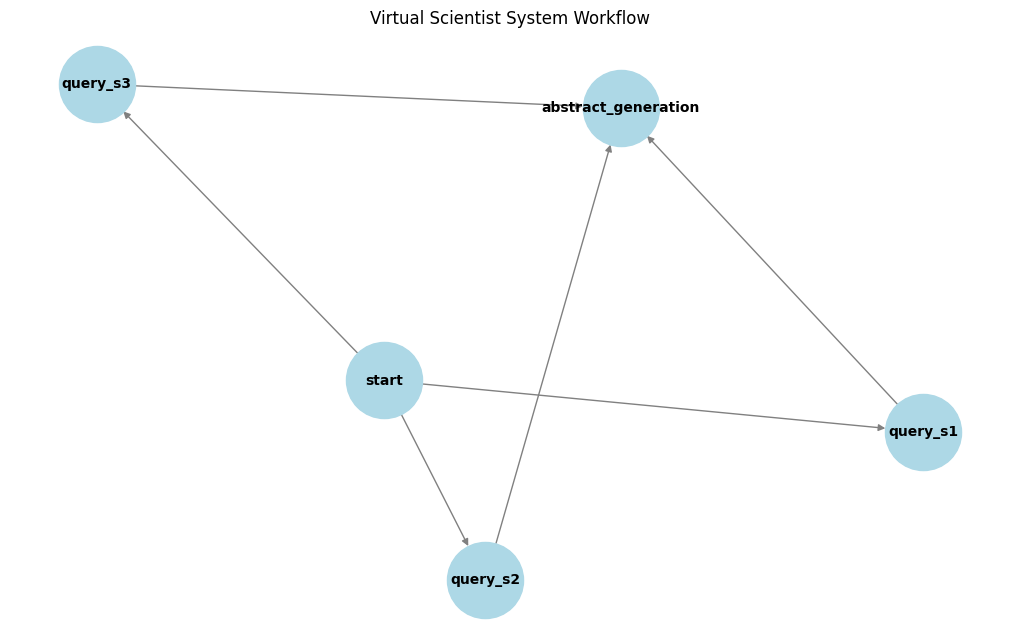

S1 is querying the agent for the topic 'Artificial Intelligence and Machine Learning'...
S2 is querying the agent for the topic 'Artificial Intelligence and Machine Learning'...
S3 is querying the agent for the topic 'Artificial Intelligence and Machine Learning'...
Response from S3: Here's the information on Artificial Intelligence and Machine Learning:

**Conclusions and Implications:**

Artificial intelligence (AI) and machine learning (ML) have revolutionized industries by inc...
Response from S2: **Artificial Intelligence and Machine Learning: Key Findings and Contributions**

Using DuckDuckGo, I've dug up some fascinating insights on the intersection of Artificial Intelligence (AI) and Machin...
Response from S1: **Title:** Exploring the Frontiers of Artificial Intelligence and Machine Learning: A Comprehensive Overview

**Purpose and Scope:**

Artificial Intelligence (AI) and Machine Learning (ML) have revolu...

--- Virtual Scientist Results ---
Topic: Artificial Intelligence a

{'topic': 'Artificial Intelligence and Machine Learning',
 's1_response': '**Title:** Exploring the Frontiers of Artificial Intelligence and Machine Learning: A Comprehensive Overview\n\n**Purpose and Scope:**\n\nArtificial Intelligence (AI) and Machine Learning (ML) have revolutionized the world by transforming the way we live, work, and interact with each other. As the demands for intelligent systems and autonomous technologies continue to grow, it is essential to understand the potential and limitations of AI and ML. This paper aims to provide a comprehensive overview of the current state of AI and ML, highlighting their applications, benefits, and challenges.\n\n**Research Problem Statement:**\n\nDespite the significant advancements in AI and ML, there remain several challenges and limitations that need to be addressed. For instance, AI and ML systems are often plagued by biases and inaccuracies, which can have serious consequences. Additionally, the increasing complexity of AI and

In [5]:
run_virtual_scientist("Artificial Intelligence and Machine Learning")